# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 28.03.2024

Мягкий дедлайн: 15.04.2024 23:59 MSK

Жёсткий дедлайн: 21.04.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). 

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [129]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [130]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [131]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        ### Step №1: Считаем степени вершин ###

        D = np.diag(np.sum(X, axis=0))

        ### Step №2: Считаем Лаплассиан ###

        L = D - X

        ### Step №3: Находим собственные вектора и собственные значения матрицы L ###

        eig_val, eig_vec = np.linalg.eigh(L)

        ### Step №4: Сортируем собственные вектора в порядке убывания собственных значений ###

        eig_vec = eig_vec[:, eig_val.argsort()]

        ### Step №5: Выводим нужное число компонент ###

        return eig_vec[:, :self.n_components]



Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [132]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [133]:
data = pd.read_excel('/Users/vsevolodparamonov/Downloads/City surface public transport stops.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index(drop=True)
data.head()

ID_en                                            Name_en  \
0    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [134]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [135]:
from collections import defaultdict
from itertools import product

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''

    routes = defaultdict(list)
    
    for i in data['ID_en'].values:

        for j in data.loc[data['ID_en'] == i, 'RouteNumbers_en'].apply(lambda x: x.split('; ')).values[0]:

            routes[j].append(i)

    return routes

def _get_dist(data, rts):

    routes_cords = np.array([[data.loc[data['ID_en'] == i, 'Latitude_WGS84_en'].values[0], 
                     data.loc[data['ID_en'] == i, 'Longitude_WGS84_en'].values[0]] for i in rts])

    distances = np.zeros((routes_cords.shape[0], routes_cords.shape[0]))

    for x, y in list(product(np.arange(len(rts)), np.arange(len(rts)))):

        distances[x, y] = np.sum((routes_cords[x, :] - routes_cords[y, :])**2)

    return distances, routes_cords




def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''

    all_routes = ['АТ18']

    all_routes = ['АБК']

    sorted_dict = defaultdict(list)

    for i in routes.keys():

        new_route = []
        ids = routes[i]
        
        distances, _ = _get_dist(data, routes[i])

        point = (np.sum(distances, axis=1) / (distances.shape[0] - 1)).argmax()

        idx = np.delete(np.arange(distances.shape[0]), point)

        for j in range(distances.shape[0]-1):

            new_point = idx[distances[point, idx].argmin()]

            idx = np.delete(idx, np.where(idx == new_point))

            new_route.append(ids[point])

            point = new_point

        new_route.append(ids[point])

        sorted_dict[i] = new_route

    return sorted_dict




def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''

    matrix = pd.DataFrame(np.zeros((data.shape[0], data.shape[0])), index = data['ID_en'], columns=data['ID_en'])


    for route in sorted_routes.values():

        matrix.loc[route, np.array(route).T] += 1

    for i in range(matrix.shape[0]):

        matrix.iat[i, i] = 0


    return matrix
    


In [136]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [137]:
np.random.seed(116)

map = folium.Map([55.75215, 37.61819], zoom_start=12)

for route_id in np.random.choice(list(sorted_routes.keys()), size=5):

    coords = [data.loc[data['ID_en'] == i, ['Latitude_WGS84_en', 'Longitude_WGS84_en']].values[0] for i in sorted_routes[route_id]]

    folium.vector_layers.PolyLine(coords).add_to(map)

map



**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [138]:
import seaborn as sns

def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''

    colors = [["#"+''.join([np.random.choice(list('ABCDEF0123456789')) for i in range(6)])] for i in range(len(np.unique(labels)))]
    color_map = {i: colors[i] for i in np.arange(len(np.unique(labels)))}
    color_map[-1] = "#"+''.join([np.random.choice(list('ABCDEF0123456789')) for i in range(6)])
    

    map = folium.Map([55.75215, 37.61819], zoom_start=12)
    
    for line, lab in zip(data.iterrows(), labels):

        id, row = line     


        folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=20, color=color_map[lab]).add_to(map)

    return map



**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

> ## <div style='color:red'> K-Means </div>

In [139]:
np.random.seed(22)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30).fit_predict(data.loc[:, ['Latitude_WGS84_en', 'Longitude_WGS84_en']])

map = draw_clustered_map(data, kmeans)

for route_id in np.random.choice(list(sorted_routes.keys()), size=10):
    coords = [data.loc[data['ID_en'] == i, ['Latitude_WGS84_en', 'Longitude_WGS84_en']].values[0] for i in sorted_routes[route_id]]
    folium.vector_layers.PolyLine(coords).add_to(map)

map

> ## <div style='color:red'> DBSCAN </div>

In [140]:
np.random.seed(60)

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.00378).fit_predict(data.loc[:, ['Latitude_WGS84_en', 'Longitude_WGS84_en']])
map = draw_clustered_map(data, dbscan)

for route_id in np.random.choice(list(sorted_routes.keys()), size=10):
    coords = [data.loc[data['ID_en'] == i, ['Latitude_WGS84_en', 'Longitude_WGS84_en']].values[0] for i in sorted_routes[route_id]]
    folium.vector_layers.PolyLine(coords).add_to(map)

map

> ## <div style='color:red'> Собственная реализация </div>

In [151]:
np.random.seed(52)

gc = GraphClustering(n_clusters=130)

map = draw_clustered_map(data, gc.fit_predict(adjacency_matrix))

for route_id in np.random.choice(list(sorted_routes.keys()), size=10):
    coords = [data.loc[data['ID_en'] == i, ['Latitude_WGS84_en', 'Longitude_WGS84_en']].values[0] for i in sorted_routes[route_id]]
    folium.vector_layers.PolyLine(coords).add_to(map)

map

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:**

> ### **<div style='color:red'> Вывод: </div>**
> 
> #### При сравнении разбиений я выявил следующее различие: <code>K-Means</code> и <code>SpectralClustering</code> стараются кластеризовать маршруты и на карте видно, что у этих моделей это неплохо получается, в то время как на карте <code>DBSCAN</code> видно, что возможны случаи выделения маленьких участков в отдельные кластеры  
>
> #### В ходе подбора можно оптимальной модели я выявил несколько минусов:
>
> * #### **Подбор параметров для DBSCAN:** Данная модель очень чувствительна к изменению параметра <code>eps</code> и очень сложно подобрать такое значение, при котором бы разбиение на кластеры было правдоподобным
>
> * #### **Подбор числа кластеров для K-Means и SpectralClustering:** Качество разбияния на кластеры очень сильно зависит от предполагаемого их числа. Например, в данной задаче мы знаем конкретное число маршрутов, поэтому и был получен такой относительно хороший результат. Однако если бы мы не знали количество истинных меток, то и кластеризация получилась бы не такой удовлетворительной
>
> #### Визуально кажется, что спектральная кластеризация показала себя лучше относительно других моделей


## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [ ]:
data = pd.read_csv('/Users/vsevolodparamonov/Downloads/bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                               title  \
503   business  504.txt   Aids and climate top Davos agenda   
1926      tech  103.txt      Camera phones are 'must-haves'   
1782     sport  470.txt     Moya emotional at Davis Cup win   
2079      tech  256.txt  Poles play with GameBoy 'blip-pop'   
1634     sport  322.txt              Scotland v Italy (Sat)   

                                                content  
503    Climate change and the fight against Aids are...  
1926   Four times more mobiles with cameras in them ...  
1782   Carlos Moya described Spain's Davis Cup victo...  
2079   A group of artists in Poland has taken the ca...  
1634   Murrayfield, Edinburgh  Saturday, 26 February...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vsevolodparamonov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vsevolodparamonov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vsevolodparamonov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [ ]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_wordcloud(texts, max_words=1000, width=1000, height=500, ax = None):

    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(14, 4))

    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)

    ax.imshow(wordcloud)
    # return wordcloud.to_image()

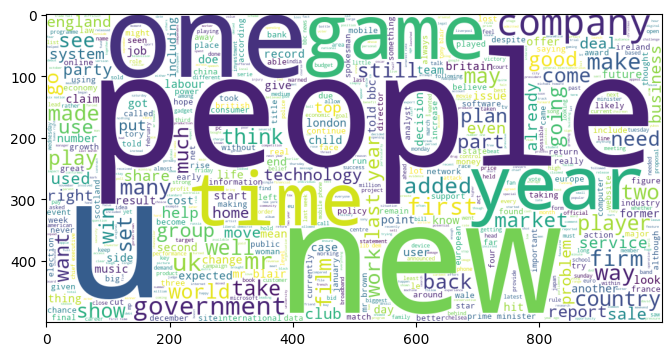

In [ ]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

td_idf_vector = TfidfVectorizer(min_df=5)

tf_data = td_idf_vector.fit_transform(data.text)


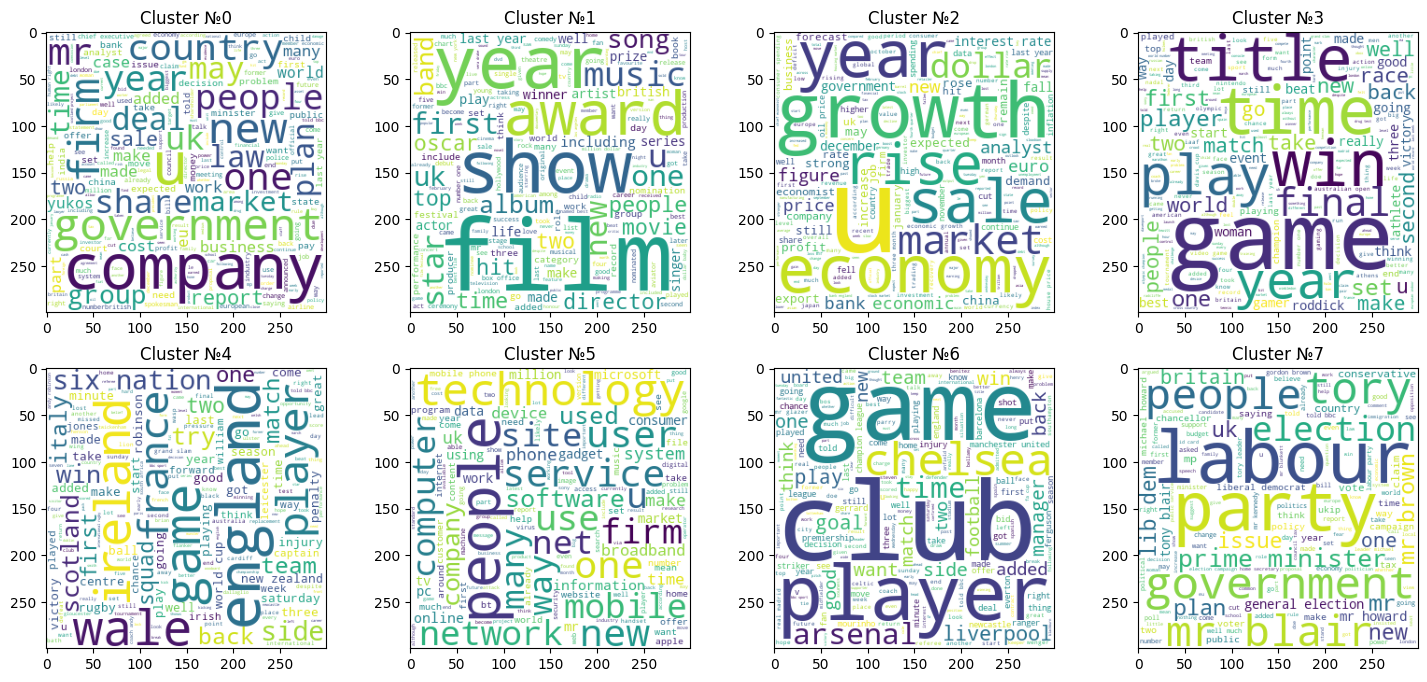

In [ ]:
k_means = KMeans(n_clusters=8).fit(tf_data)

k_pred = k_means.predict(tf_data)

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

cnt = 0

for i in np.unique(k_pred):

    idx = np.where(k_pred == i)

    smpl = data.loc[idx]

    draw_wordcloud(texts = smpl.text, width=300, height=300, ax = ax[cnt//4][cnt%4])

    ax[cnt//4][cnt%4].set_title(f'Cluster №{i}')

    cnt += 1

> ### **<div style='color:red'> Вывод: </div>**
>
> #### По графикам <code>WordCloud</code> видно, что для каждого кластера можно выделить тематику. Например, кластер №1 можно отнести к спорту из-за того, что слишком часто встречаются слова <code>Game</code>, <code>Club</code>, <code>Player</code> и тд.; в кластере №4 доминируют слова <code>Award</code>, <code>Movie</code>, <code>Oscar</code>, поэтому данный кластер можно однозначно назвать "Кинематография"

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [ ]:
all_words = td_idf_vector.get_feature_names_out()

for i in np.unique(k_means.labels_):

    idx = k_means.cluster_centers_[i].argsort()[::-1][:10]

    print(f'Кластер №{i}')
    print(', '.join(all_words[idx]), '\n')

Кластер №0
mr, company, firm, government, would, year, share, country, law, bank 

Кластер №1
film, award, best, show, star, music, band, actor, album, year 

Кластер №2
growth, economy, rate, price, sale, economic, dollar, year, market, rise 

Кластер №3
game, title, world, champion, open, olympic, win, final, race, seed 

Кластер №4
england, rugby, wale, ireland, game, france, nation, robinson, six, coach 

Кластер №5
mobile, phone, technology, people, user, service, computer, net, digital, software 

Кластер №6
club, chelsea, arsenal, game, united, league, liverpool, player, goal, manager 

Кластер №7
mr, labour, election, party, blair, tory, brown, tax, howard, would 



> ### **<div style='color:red'> Вывод: </div>**
>
> #### Да, видно, что слова приблизительно совпадают с полученными облаками тегов, однако незначительно поменялся порядок топ частовстречающихся слов 


**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [ ]:
from sklearn.cluster import SpectralClustering

####

def find_eps(data):

    epss = np.linspace(0.5, 1, 10)
    clusts = []

    for e in epss:

        dbscan = len(np.unique(DBSCAN(eps=e).fit(data).labels_))

        clusts.append(dbscan)

    return epss[np.argmin(abs(np.array(clusts) - 9))]

####


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

data_tsne = tsne.fit_transform(tf_data.toarray())

In [ ]:
from sklearn.cluster import SpectralClustering

k_means = KMeans(n_clusters=8)
dbscan = DBSCAN(eps=find_eps(data_tsne))
specClas = SpectralClustering(n_clusters=8, n_jobs=-1, n_init=5, affinity='nearest_neighbors')

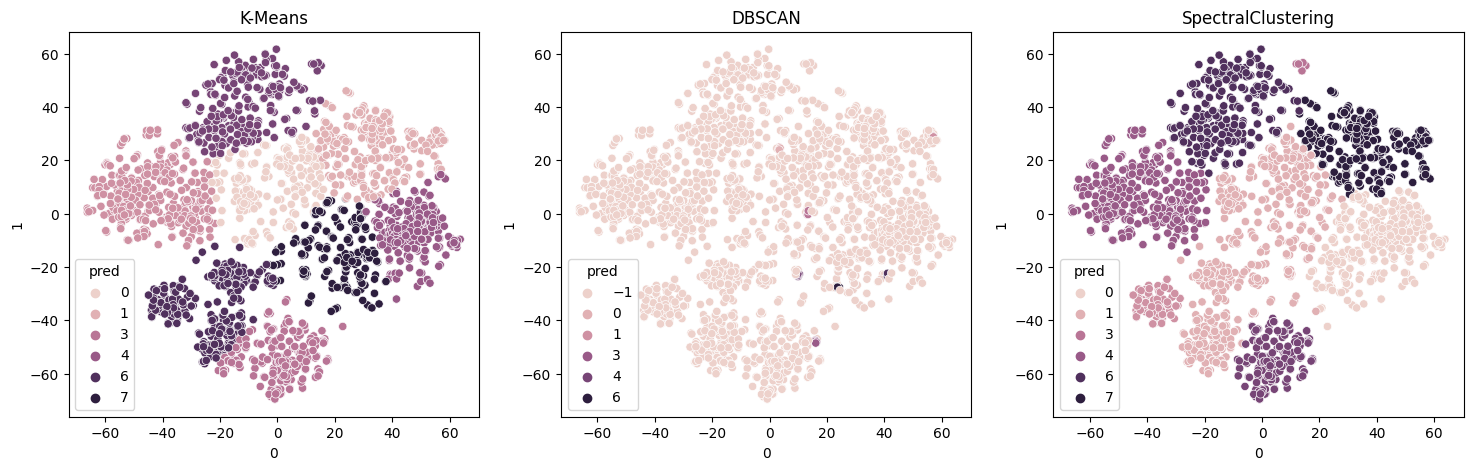

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

models = {'K-Means': k_means, 'DBSCAN': dbscan, 'SpectralClustering': specClas}

for i, mod in enumerate(models.keys()):

    pred = models[mod].fit_predict(data_tsne)

    dtt = pd.DataFrame(data_tsne)
    dtt['pred'] = pred

    sns.scatterplot(x=0, y=1, hue='pred', data=dtt, ax=ax[i])
    
    ax[i].set_title(mod)




Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**

> ### **<div style='color:red'> Вывод: </div>**
>
> #### На графиках для <code>K-Means</code> и <code>SpectralClustering</code> видно, что количество объектов в кластерах сбалансированно. Однако ситуация у <code>DBSCAN</code> не такая хороша: огромное количество объектов было отнесено к шумовому кластеру 

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()

df_bof = cnt_vec.fit_transform(data.text)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation


lda = LatentDirichletAllocation(n_components=16)


lda_transformed = lda.fit_transform(df_bof)

pred = lda_transformed.argmax(axis=1)

f'Предсказания номера кластера: {pred}'

'Предсказания номера кластера: [14 14  3 ...  3  3  0]'

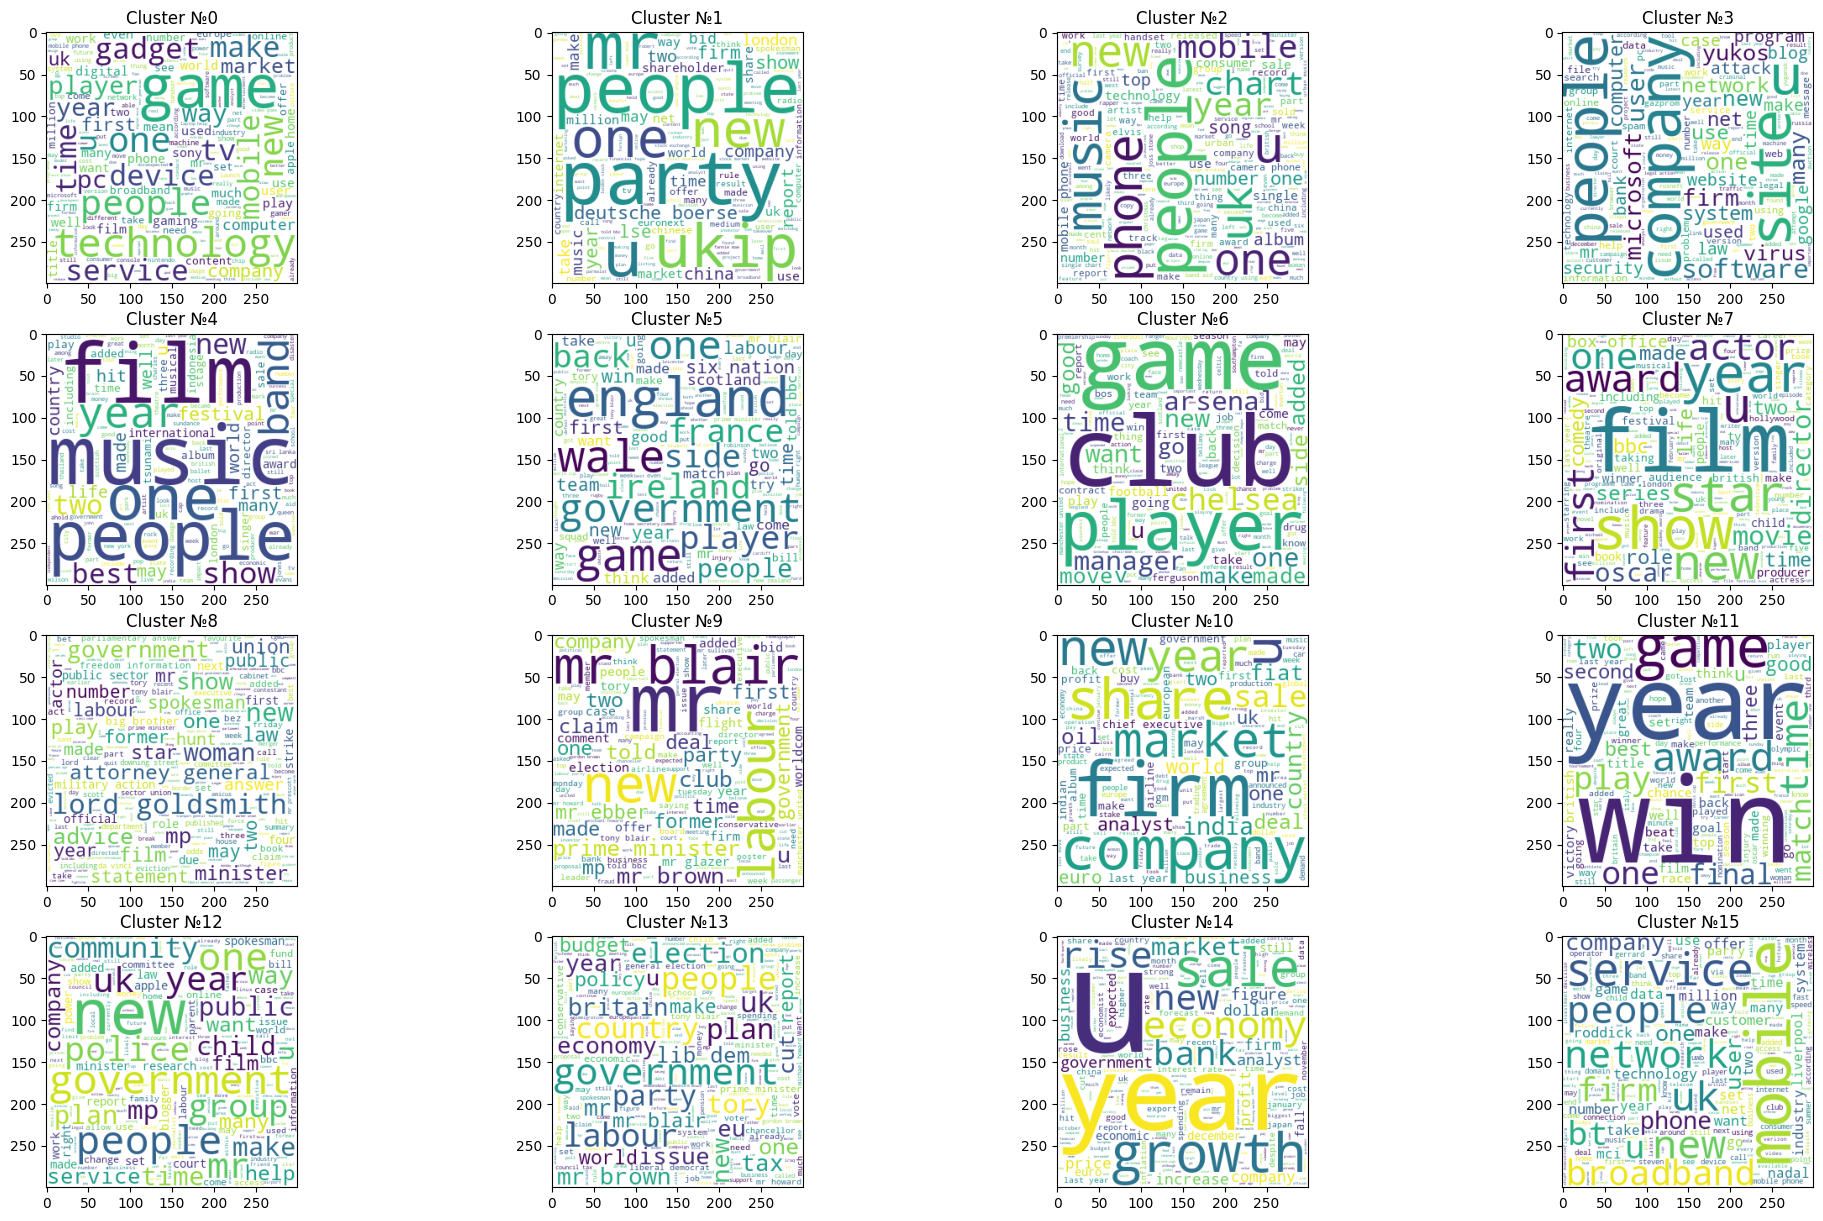

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(25, 15))

cnt = 0

for i in np.unique(pred):

    idx = np.where(pred == i)

    smpl = data.loc[idx]

    draw_wordcloud(texts = smpl.text, width=300, height=300, ax = ax[cnt//4][cnt%4])

    ax[cnt//4][cnt%4].set_title(f'Cluster №{i}')

    cnt += 1

> ### **<div style='color:red'>Вывод:</div>**
>
> #### Ориентируясь на облака слов действительно получилось получить более детализированные темы. Например, раньше было лишь два кластера, затрагивавших тему музыки и кино (на предыдущем WordCloud это кластеры №0 и №4). Сейчас же можно наблюдать, что данные темы разбились на большее число кластеров: кластеру 4 соответсвует различная медийная деятельность, связанная музыка, в то время как кластер 2 скорее отражает саму по себе музыкальную деятельность; кластер 9 связан с наградами и номинациями в сфере кинематогрофа, кластер 14 - отражает сам процесс съемки 

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data.text, data.category, test_size=0.3)

td_idf_vector = TfidfVectorizer(min_df=5)
cnt_vec = CountVectorizer()


X_train_tf = td_idf_vector.fit_transform(X_train)
X_test_tf = td_idf_vector.transform(X_test)

X_train_bow = cnt_vec.fit_transform(X_train)
X_test_bow = cnt_vec.transform(X_test)



> ### **<div style='color:cyan'>Логистическая регрессия на tf-idf признаках</div>**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_tf, y_train)

print(f'Accuracy score (train): {accuracy_score(y_train, logreg.predict(X_train_tf))}')
print(f'Accuracy score (test): {accuracy_score(y_test, logreg.predict(X_test_tf))}')

Accuracy score (train): 0.9948619139370585
Accuracy score (test): 0.9820359281437125


> ### **<div style='color:cyan'>K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров</div>**

In [ ]:
k_means = KMeans(n_clusters=len(y_train.unique()))

clust_cent = k_means.fit_transform(X_train_tf)
clust_cent_test = k_means.transform(X_test_tf)

logreg = LogisticRegression().fit(clust_cent, y_train)

print(f'Accuracy score (train): {accuracy_score(y_train, logreg.predict(clust_cent))}')
print(f'Accuracy score (test): {accuracy_score(y_test, logreg.predict(clust_cent_test))}')

Accuracy score (train): 0.8554913294797688
Accuracy score (test): 0.8473053892215568


> ### **<div style='color:cyan'>Латентное размещение Дирихле + логистическая регрессия на вероятностях тем</div>**

In [ ]:
lda = LatentDirichletAllocation(n_components=len(y_train.unique()))

train_lda = lda.fit_transform(X_train_bow)
test_lda = lda.transform(X_test_bow)

logreg = LogisticRegression().fit(train_lda, y_train)

print(f'Accuracy score (train): {accuracy_score(y_train, logreg.predict(train_lda))}')
print(f'Accuracy score (test): {accuracy_score(y_test, logreg.predict(test_lda))}')

Accuracy score (train): 0.8959537572254336
Accuracy score (test): 0.9341317365269461


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:**

> ### **<div style='color:red'>Вывод:</div>**
>
> #### Наилучшее качество получилось у модели <code>TF-IDF + LogReg</code>

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [ ]:
class CrossVal:

    def __init__(self, classif, unsup, vectorizer):

        self.model = classif
        self.cluster = unsup
        self.vec = vectorizer

    def prepare_data(self, X_train, y_train):

        X_train = self.vec.fit_transform(X_train)
        self.cluster.fit(X_train)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_train, y_train, test_size=0.3)

        self.X_65, self.X_5, self.y_65, self.y_5 = train_test_split(self.X_train, self.y_train, test_size=0.07)

    def transform_data(self):

        self.X_5 = self.cluster.transform(self.X_5)
        self.X_val = self.cluster.transform(self.X_val)

    
    def cross_valid(self, params):

        self.best_params = None
        self.best_score = 0

        for param in params:

            test_model = self.model(**param).fit(self.X_5, self.y_5)

            score = accuracy_score(self.y_val, test_model.predict(self.X_val))

            if score > self.best_score:

                self.best_score = score
                self.best_params = param


    
    def return_test_score(self, X_test, y_test):

        pred = self.model(**self.best_params).fit(self.X_5, self.y_5).predict(self.cluster.transform(self.vec.transform(X_test)))

        score = accuracy_score(y_test, pred)

        return score
    

    def compute(self, X_train, y_train, log_reg_params):

        self.prepare_data(X_train, y_train)
        self.transform_data()
        self.cross_valid(log_reg_params)

    def compute_2(self, X_train, y_train, log_reg_params):

        self.prepare_data(X_train, y_train)
        self.cross_valid(log_reg_params)



> ### **<div style='color:cyan'>TD-IDF + K-MEANS + LogReg</div>**

In [ ]:
from sklearn.model_selection import ParameterGrid

log_reg_params = ParameterGrid({'C': np.logspace(-5, 4, 20), 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']})

clustersBestScore = pd.DataFrame()

for i in range(2, 11):

    cv = CrossVal(LogisticRegression, KMeans(n_clusters=i), TfidfVectorizer(min_df=5))
    cv.compute(X_train, y_train, log_reg_params)

    clustersBestScore.loc[i, ['Val Score', 'Params']] = [cv.best_score, cv.best_params]

pd.DataFrame(clustersBestScore['Val Score'])

Val Score
2    0.386752
3    0.673077
4    0.811966
5    0.940171
6    0.942308
7    0.946581
8    0.918803
9    0.938034
10   0.950855

In [ ]:
best_clusters_num = clustersBestScore.index[clustersBestScore['Val Score'].argmax()]
best_clusters_params = clustersBestScore['Params'][clustersBestScore['Val Score'].argmax()]

td_idf = TfidfVectorizer(min_df=5).fit(X_train)
kmeans = KMeans(n_clusters = best_clusters_num).fit(td_idf.transform(X_train))

best_model = LogisticRegression(**best_clusters_params).fit(kmeans.transform(td_idf.transform(X_train)), y_train)
print(f'Accuracy score: {accuracy_score(y_test, best_model.predict(kmeans.transform(td_idf.transform(X_test))))}')

Accuracy score: 0.9535928143712575


> ### **<div style='color:cyan'>TD-IDF + LogReg</div>**

In [ ]:
from tqdm import tqdm


clustersBestScore_2 = pd.DataFrame()


for i in tqdm(range(2, 11)):

    cv = CrossVal(LogisticRegression, KMeans(n_clusters=i), TfidfVectorizer(min_df=5, max_features=500))
    cv.compute_2(X_train, y_train, log_reg_params)

    clustersBestScore_2.loc[i, ['Val Score', 'Params']] = [cv.best_score, cv.best_params]

pd.DataFrame(clustersBestScore_2['Val Score'])

100%|██████████| 9/9 [05:28<00:00, 36.50s/it]


Val Score
2    0.882479
3    0.903846
4    0.882479
5    0.905983
6    0.865385
7    0.908120
8    0.878205
9    0.871795
10   0.940171

In [ ]:
best_clusters_num = clustersBestScore_2.index[clustersBestScore_2['Val Score'].argmax()]
best_clusters_params = clustersBestScore_2['Params'][clustersBestScore_2['Val Score'].argmax()]

td_idf = TfidfVectorizer(min_df=5).fit(X_train)

best_model = LogisticRegression(**best_clusters_params).fit(td_idf.transform(X_train), y_train)
print(f'Accuracy score: {accuracy_score(y_test, best_model.predict(td_idf.transform(X_test)))}')

Accuracy score: 0.9850299401197605


> ### **<div style='color:cyan'>LDR + LogReg</div>**

In [ ]:
clustersBestScore_3 = pd.DataFrame()


for i in tqdm(range(2, 11)):

    cv = CrossVal(LogisticRegression, LatentDirichletAllocation(n_components=i), CountVectorizer())
    cv.compute(X_train, y_train, log_reg_params)

    clustersBestScore_3.loc[i, ['Val Score', 'Params']] = [cv.best_score, cv.best_params]

pd.DataFrame(clustersBestScore_3['Val Score'])

100%|██████████| 9/9 [00:35<00:00,  3.90s/it]


Val Score
2    0.431624
3    0.549145
4    0.711538
5    0.756410
6    0.784188
7    0.820513
8    0.711538
9    0.854701
10   0.809829

In [ ]:
best_clusters_num = clustersBestScore_3.index[clustersBestScore_3['Val Score'].argmax()]
best_clusters_params = clustersBestScore_3['Params'][clustersBestScore_3['Val Score'].argmax()]

cv = CountVectorizer().fit(X_train)
ldr = LatentDirichletAllocation(n_components = best_clusters_num).fit(cv.transform(X_train))

best_model = LogisticRegression(**best_clusters_params).fit(ldr.transform(cv.transform(X_train)), y_train)
print(f'Accuracy score: {accuracy_score(y_test, best_model.predict(ldr.transform(cv.transform(X_test))))}')

Accuracy score: 0.9266467065868264


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:**

> ### **<div style='color:red'>Вывод:</div>**
>
> #### По сравнению с предыдущим пунктом, лучшей моделью также осталась <code>TD-IDF + LogReg</code>, причем кросс валидация не очень сильно помогла, потому что значение <code>Accuracy</code> и так высоко. Однако стоит отметить, что подбор параметров помог модели <code>TD-IDF + K-MEANS + LogReg</code>, даная модель сравнялась с остальными и показала неплохой результат

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

> ### **<div style='color:cyan'>LabelSpreading</div>**

In [ ]:
from sklearn.semi_supervised import LabelSpreading

tf_idf = TfidfVectorizer(min_df=2)
data_ls = tf_idf.fit_transform(data.text)

lbl = data.category.copy()

### Специально уберем часть размеченных данных ###

noise = 0.8
lbl.loc[np.random.choice(np.arange(lbl.shape[0]), int(lbl.shape[0] * noise))] = 'Unknown'

###

mapper = {lbl.unique()[i]: i for i in range(len(lbl.unique()))}
mapper['Unknown'] = -1

decoder = {i: j for j, i in mapper.items()}

lbl.replace(mapper, inplace=True)

labSpread =  LabelSpreading()

labSpread.fit(data_ls, lbl)

pred_labSpread = [decoder[i] for i in labSpread.predict(data_ls)]

print(f'Accuracy score: {accuracy_score(data.category, pred_labSpread)}')

Accuracy score: 0.9573033707865168


> #### Модель <code>LabelSpreading</code> показала себя неплохо при условии, что разметка была лишь у 20% объектов. Посмотрим, как доля размеченных объектов может повлиять на <code>Accuracy</code>

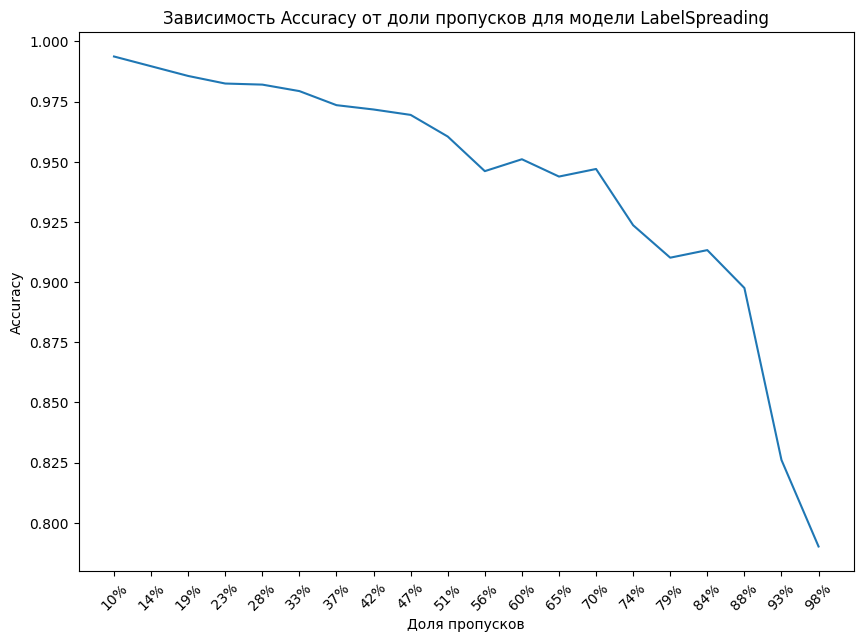

In [ ]:
noises = np.linspace(0.1, 0.98, 20)

accuracies = []

for noise in noises:

    lbl = data.category.copy()
    lbl.loc[np.random.choice(np.arange(lbl.shape[0]), int(lbl.shape[0] * noise), replace=False)] = 'Unknown'

    mapper = {lbl.unique()[i]: i for i in range(len(lbl.unique()))}
    mapper['Unknown'] = -1
    decoder = {i: j for j, i in mapper.items()}

    lbl.replace(mapper, inplace=True)


    labSpread =  LabelSpreading()
    labSpread.fit(data_ls, lbl)
    pred_labSpread = [decoder[i] for i in labSpread.predict(data_ls)]

    accuracies.append(accuracy_score(data.category, pred_labSpread))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(np.core.defchararray.add((noises * 100).astype(int).astype(str), '%'), accuracies)
ax.set_xticklabels(np.core.defchararray.add((noises * 100).astype(int).astype(str), '%'), rotation=45)
ax.set_xlabel('Доля пропусков')
ax.set_ylabel('Accuracy')
ax.set_title('Зависимость Accuracy от доли пропусков для модели LabelSpreading');

> ### **<div style='color:red'>Вывод:</div>**
>
> #### По графику можно определить, что данный метод лучше работает, чем те, которые мы рассматривали ранее, при доле пропусков меньше $\approx$ 25%, там значение <code>Accuracy</code> очень высоко

> ### **<div style='color:cyan'>SelfTrainingClassifier + RandomForest</div>**

In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier

tf_idf = TfidfVectorizer(min_df=2)
data_ls = tf_idf.fit_transform(data.text)

lbl = data.category.copy()

### Специально уберем часть размеченных данных ###

noise = 0.8
lbl.loc[np.random.choice(np.arange(lbl.shape[0]), int(lbl.shape[0] * noise))] = 'Unknown'

###

mapper = {lbl.unique()[i]: i for i in range(len(lbl.unique()))}
mapper['Unknown'] = -1

semiTrainer = SelfTrainingClassifier(RandomForestClassifier())
semiTrainer.fit(data_ls, lbl)

print(f'Accuracy score: {accuracy_score(data.category, semiTrainer.predict(data_ls))}')

Accuracy score: 0.4368539325842697


> #### Метод <code>SelfTrainingClassifier</code> работает уже не так хорошо в сравнении с <code>LabelSpreading</code>. Конечно можно сделать подбор параметров для базовой модели, но этот метод все равно уступает <code>LabelSpreading</code>. В качестве базовой модели я взял <code>RandomForest</code>, но даже это не помогло добиться примерно похожих метрик для предыдущей модели. Точно также посмотрим на зависимость <code>Accuracy</code> от доли пропусков в разметке:

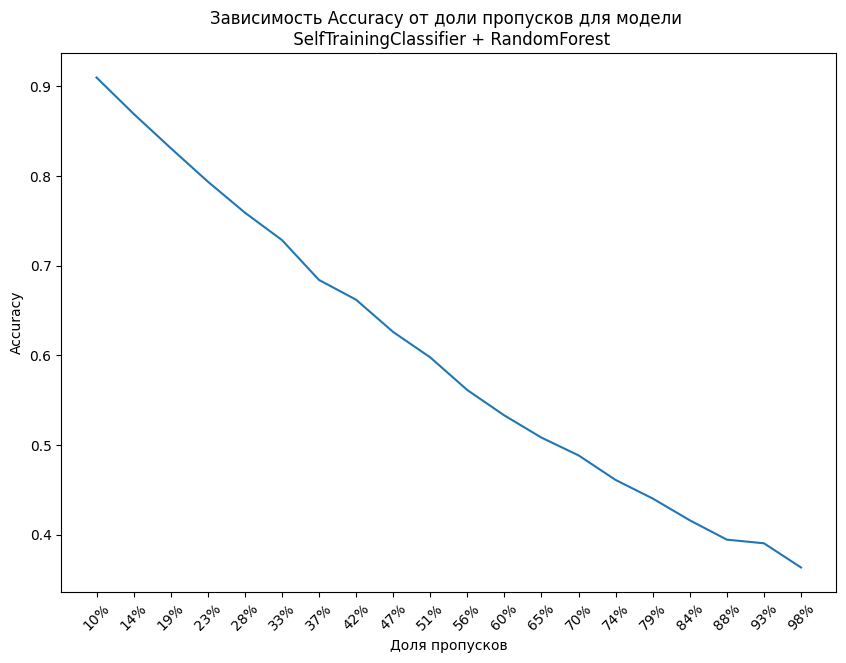

In [ ]:
accuracies = []

for noise in noises:
        
        lbl = data.category.copy()

        ### Специально уберем часть размеченных данных ###

        lbl.loc[np.random.choice(np.arange(lbl.shape[0]), int(lbl.shape[0] * noise))] = 'Unknown'

        ###

        mapper = {lbl.unique()[i]: i for i in range(len(lbl.unique()))}
        mapper['Unknown'] = -1

        semiTrainer = SelfTrainingClassifier(RandomForestClassifier())
        semiTrainer.fit(data_ls, lbl)

        accuracies.append(accuracy_score(data.category, semiTrainer.predict(data_ls)))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(np.core.defchararray.add((noises * 100).astype(int).astype(str), '%'), accuracies)
ax.set_xticklabels(np.core.defchararray.add((noises * 100).astype(int).astype(str), '%'), rotation=45)
ax.set_xlabel('Доля пропусков')
ax.set_ylabel('Accuracy')
ax.set_title('Зависимость Accuracy от доли пропусков для модели \n SelfTrainingClassifier + RandomForest');

> ### **<div style='color:red'>Вывод:</div>**
>
> #### На графике видно, что значение <code>Accuracy</code> стремительно падает при росте доли пропусков в разметке, чем уступает модели <code>LabelSpreading</code>

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [ ]:
def BCubed(g, c):

    C_eq_C_dot = c == c.reshape(-1,1)

    L_eq_L_dot = g == g.reshape(-1,1)

    correctness = (C_eq_C_dot == L_eq_L_dot)

    prec = np.mean(np.mean(correctness, where=C_eq_C_dot))
    recall = np.mean(np.mean(correctness, where=L_eq_L_dot))

    bcubed = 2 * prec * recall / (recall + prec)

    return bcubed


> ### **<div style='color:cyan'>TD-IDF + K-MEANS + LogReg</div>**


In [ ]:
best_clusters_num = clustersBestScore.index[clustersBestScore['Val Score'].argmax()]
best_clusters_params = clustersBestScore['Params'][clustersBestScore['Val Score'].argmax()]

td_idf = TfidfVectorizer(min_df=5).fit(X_train)
kmeans = KMeans(n_clusters = best_clusters_num).fit(td_idf.transform(X_train))

best_model = LogisticRegression(**best_clusters_params).fit(kmeans.transform(td_idf.transform(X_train)), y_train)
print(f'BCubed Score: {BCubed(y_test.values, best_model.predict(kmeans.transform(td_idf.transform(X_test))))}')

BCubed Score: 0.9162940830080042


> ### **<div style='color:cyan'>TD-IDF + LogReg</div>**


In [ ]:
best_clusters_num = clustersBestScore_2.index[clustersBestScore_2['Val Score'].argmax()]
best_clusters_params = clustersBestScore_2['Params'][clustersBestScore_2['Val Score'].argmax()]

td_idf = TfidfVectorizer(min_df=5).fit(X_train)

best_model = LogisticRegression(**best_clusters_params).fit(td_idf.transform(X_train), y_train)
print(f'BCubed Score: {BCubed(y_test.values, best_model.predict(td_idf.transform(X_test)))}')

BCubed Score: 0.9725726163776599


> ### **<div style='color:cyan'>LDR + LogReg</div>**


In [ ]:
best_clusters_num = clustersBestScore_3.index[clustersBestScore_3['Val Score'].argmax()]
best_clusters_params = clustersBestScore_3['Params'][clustersBestScore_3['Val Score'].argmax()]

cv = CountVectorizer().fit(X_train)
ldr = LatentDirichletAllocation(n_components = best_clusters_num).fit(cv.transform(X_train))

best_model = LogisticRegression(**best_clusters_params).fit(ldr.transform(cv.transform(X_train)), y_train)
print(f'BCubed: {BCubed(y_test.values, best_model.predict(ldr.transform(cv.transform(X_test))))}')

BCubed: 0.8857582079718898


> ### **<div style='color:red'>Вывод:</div>**
>
> #### <code>TD-IDF + LogReg</code> оказалось лучше по метрике <code>BCubed</code>. Такой же результат мы получили и в предыдущих пунктах, когда мы сравнивали модели по <code>Accuracy</code>


**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

> #### Я выбрал датасет CIFAR-10 - датасет из 32x32 цветных изображений, разделенных на 10 классов

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

> #### Я решил не использовать все 50.000 наблюдений, а решил оставить только 4.000

In [ ]:
idx = np.random.choice(np.arange(x_train.shape[0]), 4000, replace=True)

x_train = x_train[idx, :]
y_train = y_train[idx]

In [ ]:
import umap
from sklearn.decomposition import KernelPCA

k_means_comp = pd.DataFrame()
dbscan_comp = pd.DataFrame()
spec_comp = pd.DataFrame()

dataset_umap = umap.UMAP(n_neighbors = 15, min_dist = 0.2,
                          n_components = 2).fit_transform(x_train.reshape(x_train.shape[0], -1))

dataset_pca = KernelPCA(n_components = 2, kernel = 'rbf', 
                        gamma = 10).fit_transform(x_train.reshape(x_train.shape[0], -1))


> ### **<div style='color:cyan'>K-MEANS</div>**

In [ ]:
k_means_tst = KMeans(n_clusters=10)

k_means_comp.loc['UMAP', ['BCubed','Accuracy']] = [BCubed(y_train, k_means_tst.fit_predict(dataset_umap)),
                                                   accuracy_score(y_train, k_means_tst.predict(dataset_umap))]

k_means_comp.loc['KernelPCA', ['BCubed','Accuracy']] = [BCubed(y_train, k_means_tst.fit_predict(dataset_pca)),
                                                   accuracy_score(y_train, k_means_tst.predict(dataset_pca))]

k_means_comp

BCubed  Accuracy
UMAP       0.185085   0.10725
KernelPCA  0.946158   0.10350

> ### **<div style='color:cyan'>DBSCAN</div>**

In [ ]:
dbscan_tst = DBSCAN(0.05)

dbscan_comp.loc['UMAP', ['BCubed','Accuracy']] = [BCubed(y_train, dbscan_tst.fit_predict(dataset_umap)),
                                                   accuracy_score(y_train, dbscan_tst.fit_predict(dataset_umap))]

dbscan_comp.loc['KernelPCA', ['BCubed','Accuracy']] = [BCubed(y_train, dbscan_tst.fit_predict(dataset_pca)),
                                                   accuracy_score(y_train, dbscan_tst.fit_predict(dataset_pca))]

dbscan_comp

BCubed  Accuracy
UMAP       0.968803   0.00125
KernelPCA  0.995500   0.10100

> ### **<div style='color:cyan'>SpectralClustering</div>**

In [ ]:
spec_tst = SpectralClustering(n_clusters=10)

spec_comp.loc['UMAP', ['BCubed','Accuracy']] = [BCubed(y_train, spec_tst.fit_predict(dataset_umap)),
                                                   accuracy_score(y_train, spec_tst.fit_predict(dataset_umap))]

spec_comp.loc['KernelPCA', ['BCubed','Accuracy']] = [BCubed(y_train, spec_tst.fit_predict(dataset_pca)),
                                                   accuracy_score(y_train, spec_tst.fit_predict(dataset_pca))]

spec_comp

BCubed  Accuracy
UMAP       0.224849    0.1135
KernelPCA  0.551599    0.1050

In [ ]:
scat_umap = pd.DataFrame(dataset_umap)

scat_umap['SC'] = spec_tst.fit_predict(dataset_umap)
scat_umap['K-Means'] = k_means_tst.fit_predict(dataset_umap)
scat_umap['DBSCAN'] = dbscan_tst.fit_predict(dataset_umap)
scat_umap['True'] = y_train

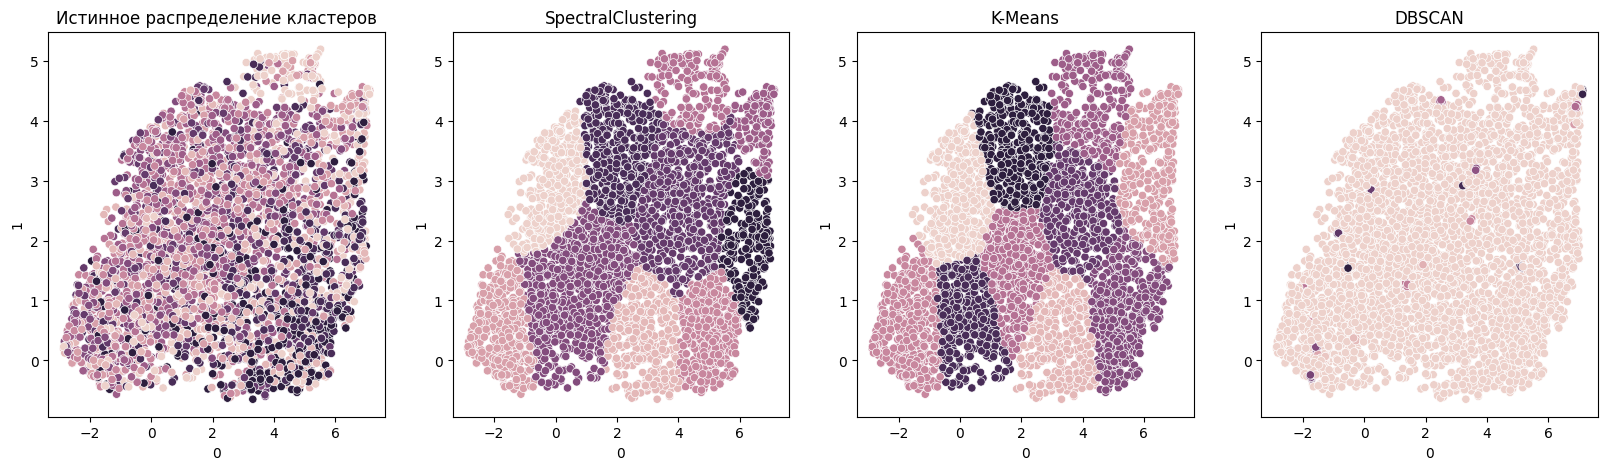

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].set_title('Истинное распределение кластеров')
sns.scatterplot(scat_umap, x=0, y=1, hue='True', ax=ax[0], legend=False)

ax[1].set_title('SpectralClustering')
sns.scatterplot(scat_umap, x=0, y=1, hue='SC', ax=ax[1], legend=False)

ax[2].set_title('K-Means')
sns.scatterplot(scat_umap, x=0, y=1, hue='K-Means', ax=ax[2], legend=False)

ax[3].set_title('DBSCAN')
sns.scatterplot(scat_umap, x=0, y=1, hue='DBSCAN', ax=ax[3], legend=False);

In [ ]:
scat_pca = pd.DataFrame(dataset_pca)

scat_pca['SC'] = spec_tst.fit_predict(dataset_pca)
scat_pca['K-Means'] = k_means_tst.fit_predict(dataset_pca)
scat_pca['DBSCAN'] = dbscan_tst.fit_predict(dataset_pca)
scat_pca['True'] = y_train

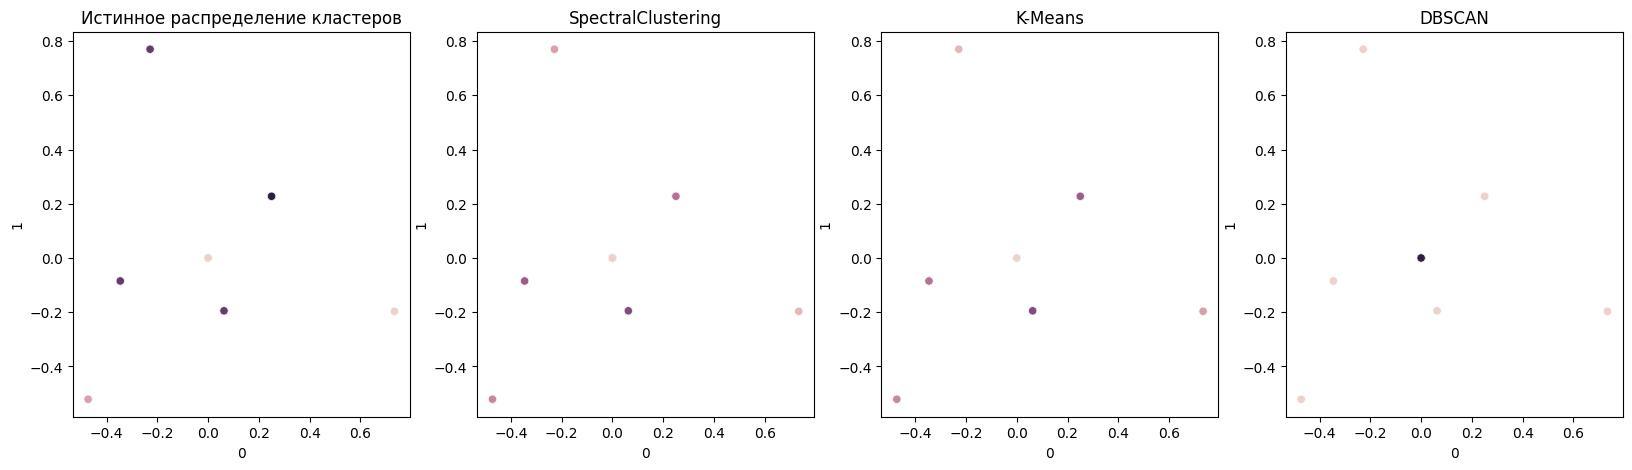

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].set_title('Истинное распределение кластеров')
sns.scatterplot(scat_pca, x=0, y=1, hue='True', ax=ax[0], legend=False)

ax[1].set_title('SpectralClustering')
sns.scatterplot(scat_pca, x=0, y=1, hue='SC', ax=ax[1], legend=False)

ax[2].set_title('K-Means')
sns.scatterplot(scat_pca, x=0, y=1, hue='K-Means', ax=ax[2], legend=False)

ax[3].set_title('DBSCAN')
sns.scatterplot(scat_pca, x=0, y=1, hue='DBSCAN', ax=ax[3], legend=False);

> ### **<div style='color:red'>Вывод:</div>**
>
> #### Для всех моделей, которые были в рассмотрении, использование <code>KernelPCA</code> дало наилучший результат по метрике <code>BCubed</code>. Причем в задаче кластеризации изображений <code>DBScan</code> показал себя лучше всех, а в задачах из основной части он всегда отставал. Стоит принять во внимание, что мне не удалось перебрать оптимальные параметры, поэтому, возможно, можно получить более удовлетворительные метрики. Прокомментирую такие странные графики для <code>KernelPCA</code>, там получились достаточно близкие точки и их кооридинаты принимают очень маленькие значения и видно, что точки можно хорошо разделить $\Rightarrow$ кластеризовать
>
> #### Для <code>UMAP</code> ситуация не очень хорошая: <code>UMAP</code> достаточно плохо сжал данные до двух компонент и по графику истинниого распределения меток можно предположить, что получившиеся данные очень тяжело кластеризовать 

**Задание 7 (1 балл)**. Наконец, ставший ежегодной традицией социализационный бонус. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за это задание, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

Это я в Эрарте был

<center>

<img height='400' src='https://lh3.googleusercontent.com/fife/ALs6j_HcJ7LAyFoRWIj_w2O1U0wm-wOO07b2yObAFocmwoQGjzoSqt0Th3PjWPpuTNAWMjLz4KdQKTQPW0fJfZSmdhWYbCsK31SBLZb_oE_EUTCbuiXGcBbHdWnyJEbCF3nlRl1_p-_U5coC0-Y7iPaYI1zIXXyqkXsaxJ3oyDPe1_VU_pqISuvFHqXmavNHt9eXNRgviqdfmPX-zBeyboVzj-JQORwMUyEJy50XM_zYxRxETTt62jqXPeGpGdp6QWNJKOaHppq-JUbQRceBCLDzYvbYpIguzY-evNBlPelvOAur26m_KK4UBVIwdHhJ9WJaAP-CoPVF1Ko3rI4tQXgu2JkJG9P0lSAktUjVGhI7Hh9xEFzMAEs0o90jzDUJDrB1ANxBprLTf817W7LMEgway143d9nDDOa-U7l9S8-ShfFcnL8AWkMiQNzO1PIwksXgk0rL9sKoMoNG4bLlGXSpOntjy--ya-sRfdUehaSsg_WltJh9W2l2IBcg4o3LfNp7R77NOVU7RPSOMV-rOABbTxKft1u82kT-BDdclS1o_8ka-JUm06978yHmByARp3NwFNkBqwpK4WsupMrdZKZw3ihSHwo2j4Re7AM4hBEt3GxBHNYEWBv2wkPdsilA4cX9f9M2xfY2YOcx2PECPYxk5XvROpghXTXySkbw45kpFxZWXHXbHY0P40mesvfB33div4y_xdWizEvXg1yi3DDKpC8m3-VgKke3v8u4mNfvpm22M3FFf7lOS2aAOUIEdjlNF50Q5NtPR6gowHEEEaIlTihdYuKWnkR_DmxY4meZ7-VoebaWQDYDBM-3oZ_HCbcMOVXbBzZRsT54dEgDLAkKpfJ7VWXaS1Qo2mdYaIFJkBKrzNbJBVRGkEBQQ1CDqvJj3gwTyKOpxYLymklzqbnBqp_Vc-7K0wPAGZAJA0jtzEBU0k6r6SkvA4tklmaUMLYT2flKND1rRihNgRGpFVvbb6FYT9rkw1CsjBXa9a6YR9WjgMMxwfXS8FCLeMPZL0HNT3lzt_w1NgFn_Ntmtq7DxTin9I76DaT3iWWurKnE4GUrkitwxd0iC6hvJasbjIQOKiFxhfKvR-eYI2eYA-D1Z7KNOpToh_BHQjD6liLJuFaNL05-EzDfDpzfdmlcWIHVmua1w20ctkOfLS3QIiqYPBKvgrY6g0NuCNKcPjdTBl5EQ6iXL6X3o1nZbTK_KEzEMMbN2P7V1IFm0eaCVIlJ4GH8zmd9w6Hkt_vjif50858gFnIbEXqQ26iKcHI1gsBnR6ckhwSJTJq068zA3hlCzcQ7Va4kwetYuTpcfqkvvCVS3wl1jq6aixei6cOJdKX7dKYFY0Ya8SNCmzAiIb4u4ftki6_egXXqYFr-Y5zbtIKV6-hLLkCs960IvUU7axavuBF9cNbUfgdAiveUBiTS5sUNHVVb0Vy0wzXQj0-o1kjGNRtBfzIsNJQ-mTSn6to92oa09rvTXuoy1hUq6hf2lCvG7E7iXop4kyMiJdmX4KehiANR60PTPdExMh975LSRrzjuKh8rVXei_Vf2nFMBQVmWxbDjXJd7iUv60I1nx9lUZwzUeQRW1P6L8coX82_2ttCu9i1xQ6ZWwsYaUlWhdyNmmQPKh3yXJ7g8jSFscuSDLVHVEvenyePvrvm2Neq-8_E4nI2NEKwJHLlb9TkdoGYkpwY=w2928-h1736'>

</center>